In [126]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from pylab import rcParams
rcParams['figure.figsize'] = 15,5

### Задание

#### Цель: 
Закрепить знания о математическом смысле метрик TPR, FPR. Изучить построение ROC-кривой, графика Precision-Recall.


#### Описание задания:

Решить задачу классификации при помощи обучения модели логистической регрессии. Качество модели оценивается путем подсчета метрик TPR, FPR и построения графиков ROC-кривой, Precision-Recall. Данные для обучения модели хранятся в файле athletes.csv, который можно найти в материалах к занятию.

#### Этапы работы:

1. Преобразуйте данные:
- a. проверьте наличие пропущенных значений. Преобразуйте/удалите пропуски по необходимости;
- b. закодируйте категориальные переменные числовыми значениями по необходимости.

2. Разделите выборку на обучающее (80% данных) и тестовое (20% данных) подмножества.
3. Постройте ROC-кривую с помощью функции sklearn.metrics. roc_curve.
4. Вычислите значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.
5. Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.
6. Постройте ROC-кривую с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.
7. Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.
8. Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.
9. Сформулируйте выводы по проделанной работе:
- a. как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик?
- b. может ли ROC-кривая проходить ниже диагонали

In [3]:
data = pd.read_csv('athletes.csv')
data.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


#### 1. Преобразуйте данные:
- a. проверьте наличие пропущенных значений. Преобразуйте/удалите пропуски по необходимости;
- b. закодируйте категориальные переменные числовыми значениями по необходимости.

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10858 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10858 non-null  int64  
 1   name         10858 non-null  object 
 2   nationality  10858 non-null  object 
 3   sex          10858 non-null  object 
 4   dob          10858 non-null  object 
 5   height       10858 non-null  float64
 6   weight       10858 non-null  float64
 7   sport        10858 non-null  object 
 8   gold         10858 non-null  int64  
 9   silver       10858 non-null  int64  
 10  bronze       10858 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 1017.9+ KB


In [10]:
# чисто теоретически можно было бы поработать с пропусками, попытавшись воссоздать их значения аналитически, но будем проще
data = data.dropna(axis=0)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10858 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10858 non-null  int64  
 1   name         10858 non-null  object 
 2   nationality  10858 non-null  object 
 3   sex          10858 non-null  object 
 4   dob          10858 non-null  object 
 5   height       10858 non-null  float64
 6   weight       10858 non-null  float64
 7   sport        10858 non-null  object 
 8   gold         10858 non-null  int64  
 9   silver       10858 non-null  int64  
 10  bronze       10858 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 1017.9+ KB


In [14]:
#в качестве Y возьмем пол и видим, что данные требуют кодирования
data['sex'].unique()

array(['male', 'female'], dtype=object)

In [25]:
le = LabelEncoder()
le.fit( data['sex'] )

LabelEncoder()

In [29]:
Y = pd.Series(data = le.transform(data['sex']))
Y.head()

0    1
1    0
2    1
3    1
4    1
dtype: int32

Теперь разберемся с Х

In [33]:
datax = data.drop(['id', 'name', 'sport', 'sex'], axis=1)
datax.head()

,nationality,dob,height,weight,gold,silver,bronze
0,ESP,10/17/69,1.72,64.0,0,0,0
1,KOR,9/23/86,1.68,56.0,0,0,0
2,CAN,5/27/92,1.98,79.0,0,0,1
3,MDA,1/2/91,1.83,80.0,0,0,0
4,NZL,11/26/90,1.81,71.0,0,0,0


#### Почему я убрал колонку Sport.
данная колонка актуальна в том случае, если мы хотим сделать прогноз конкретно по выборке, относящейся к определенному виду спорта. В данном же случае нас больше интересует вообще количество медалистов вне зависимости от вида спорта. Т.о., эта колонка будеи просто лишней и может созлдавать дополнительный шум при обучении

In [34]:
X = pd.get_dummies(datax, columns=['nationality', 'dob', 'height', 'weight', 'gold', 'silver', 'bronze'])

In [138]:
X.head()

,nationality_AFG,nationality_ALB,nationality_ALG,nationality_AND,nationality_ANG,nationality_ANT,nationality_ARG,nationality_ARM,nationality_ARU,nationality_ASA,...,gold_2,gold_3,gold_4,gold_5,silver_0,silver_1,silver_2,bronze_0,bronze_1,bronze_2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


#### 2. Разделите выборку на обучающее (80% данных) и тестовое (20% данных) подмножества.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [39]:
model = LogisticRegression()

In [40]:
model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [43]:
model.score(X_train, y_train) 

0.8650702279530279

In [140]:
model.score(X_test, y_test) 

0.8043278084714549

#### 3. Постройте ROC-кривую с помощью функции sklearn.metrics. roc_curve.

In [47]:
fpr, tpr, thres = roc_curve( y_test, predictions[:, 1])

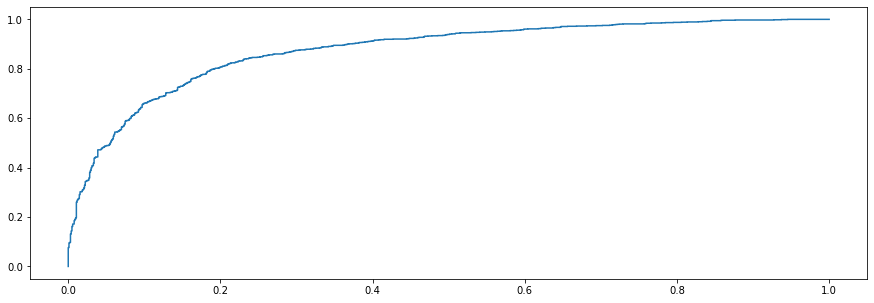

In [127]:
plt.plot( fpr, tpr )

#### 4. Вычислите значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.

In [142]:
roc_auc_score(y_test, predictions[:, 1])

0.8744627038239846

#### 5. Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.

In [120]:
tp = 0 # True positive
fp = 0 # False positive
fn = 0 # False negative
tn = 0 # True negative
tpr_list = [] # True positive_list
fpr_list = [] # False positive_list
precision = [] # понадобится для дальнешего построения графика precision / recall
P = sum(y_test) # данное значение равно TP+ FN
N = len(y_test) - P # данное значение равно FP + TN
for predicted_prob, actual in zip( predictions[:, 1], y_test ):    
    if predicted_prob >= 0.5:
        predicted = 1
    else:
        predicted = 0
    
    if predicted == 1:
        if actual == 1:
            tp += 1
    
        else:
            fp += 1
    
    else:
        if actual == 1:
            fn += 1
        else:
            tn += 1
    tpr_list.append(tp/P)
    fpr_list.append(fp/N)
    precision.append(actual/(tp+fp))

In [115]:
accuracy = (tp + tn) / (tp + fp + fn + tn)
accuracy # Совпадает со значением model.score

0.8043278084714549

#### 6. Постройте ROC-кривую с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.

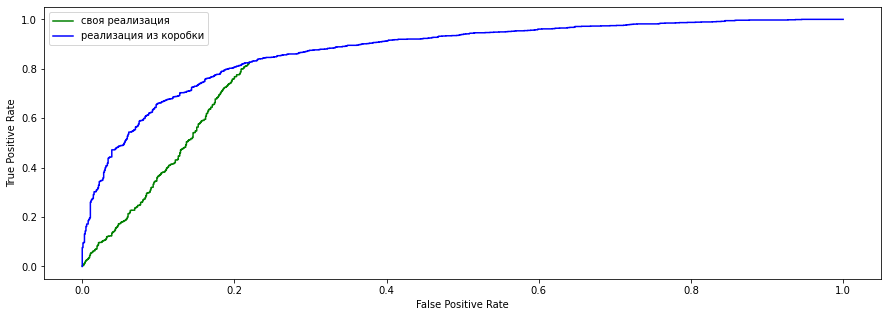

In [128]:
# plt.plot()
plt.plot(fpr_list,tpr_list, label = 'своя реализация', c='g' )
plt.plot(fpr,tpr, label = 'реализация из коробки', c='b' )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend( loc = 0 )
plt.show()


В общем, вывод следующий: реализовать реализовал но как-то криво.

#### 7. Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.

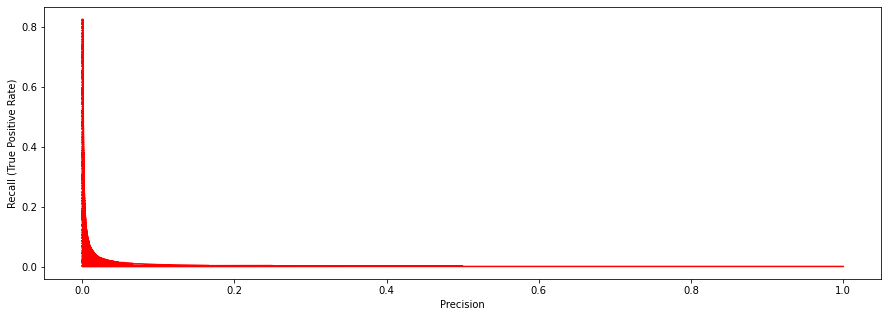

In [132]:
plt.plot(precision,tpr_list, c='r' )
plt.xlabel('Precision')
plt.ylabel('Recall (True Positive Rate)')

plt.show()

#### 8. Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5


In [133]:
from sklearn.metrics import auc

In [134]:
auc( fpr_list, tpr_list )

0.08855015047693537

почему-то значение практически в 10 раз меньше того, что было получено функцией "из коробки"

#### 9. Сформулируйте выводы по проделанной работе:
- a. как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик?
- b. может ли ROC-кривая проходить ниже диагонали

- а. моя реализация оставляет желать лучшего. Подозреваю, что что-то не учел (treshold?), либо напутал в коде.
- b. если качество модели плохое, то вполне может